In [3]:
"""
Starter code for the problem "MPC feasibility".

Autonomous Systems Lab (ASL), Stanford University
"""

from itertools import product

import cvxpy as cvx

import matplotlib.pyplot as plt

import numpy as np

from scipy.linalg import solve_discrete_are

from tqdm.auto import tqdm

## Part A

In [53]:
def do_mpc(
    x0: np.ndarray,
    A: np.ndarray,
    B: np.ndarray,
    P: np.ndarray,
    Q: np.ndarray,
    R: np.ndarray,
    N: int,
    rx: float,
    ru: float,
    rf: float,
) -> tuple[np.ndarray, np.ndarray, str]:
    """Solve the MPC problem starting at state `x0`."""
    n, m = Q.shape[0], R.shape[0]
    x_cvx = cvx.Variable((N + 1, n))
    u_cvx = cvx.Variable((N, m))

    # PART (a): YOUR CODE BELOW ###############################################
    # INSTRUCTIONS: Construct and solve the MPC problem using CVXPY.

    cost = 0.0
    constraints = []

    for i in range(N):
        cost += cvx.quad_form(x_cvx[i,:], Q)
        cost += cvx.quad_form(u_cvx[i,:], R)
    cost += cvx.quad_form(x_cvx[-1,:], P)
    

    # state, input, and terminal constraints
    constraints += [ cvx.max(cvx.abs(x_cvx[:,:])) <= rx]
    constraints += [ cvx.max(cvx.abs(u_cvx[:-1,:])) <= ru]
    constraints += [ cvx.max(cvx.abs(x_cvx[-1,:])) <= rf]
    constraints += [ x_cvx[i+1,:] == A @ x_cvx[i,:] + B @ u_cvx[i,:] for i in range(N)]
    constraints += [ x_cvx[0,:] == x0 ]

    # END PART (a) ############################################################

    prob = cvx.Problem(cvx.Minimize(cost), constraints)
    prob.solve()
    x = x_cvx.value
    u = u_cvx.value
    status = prob.status 

    return x, u, status

IC 1  hit infeasibility
IC 1  hit infeasibility


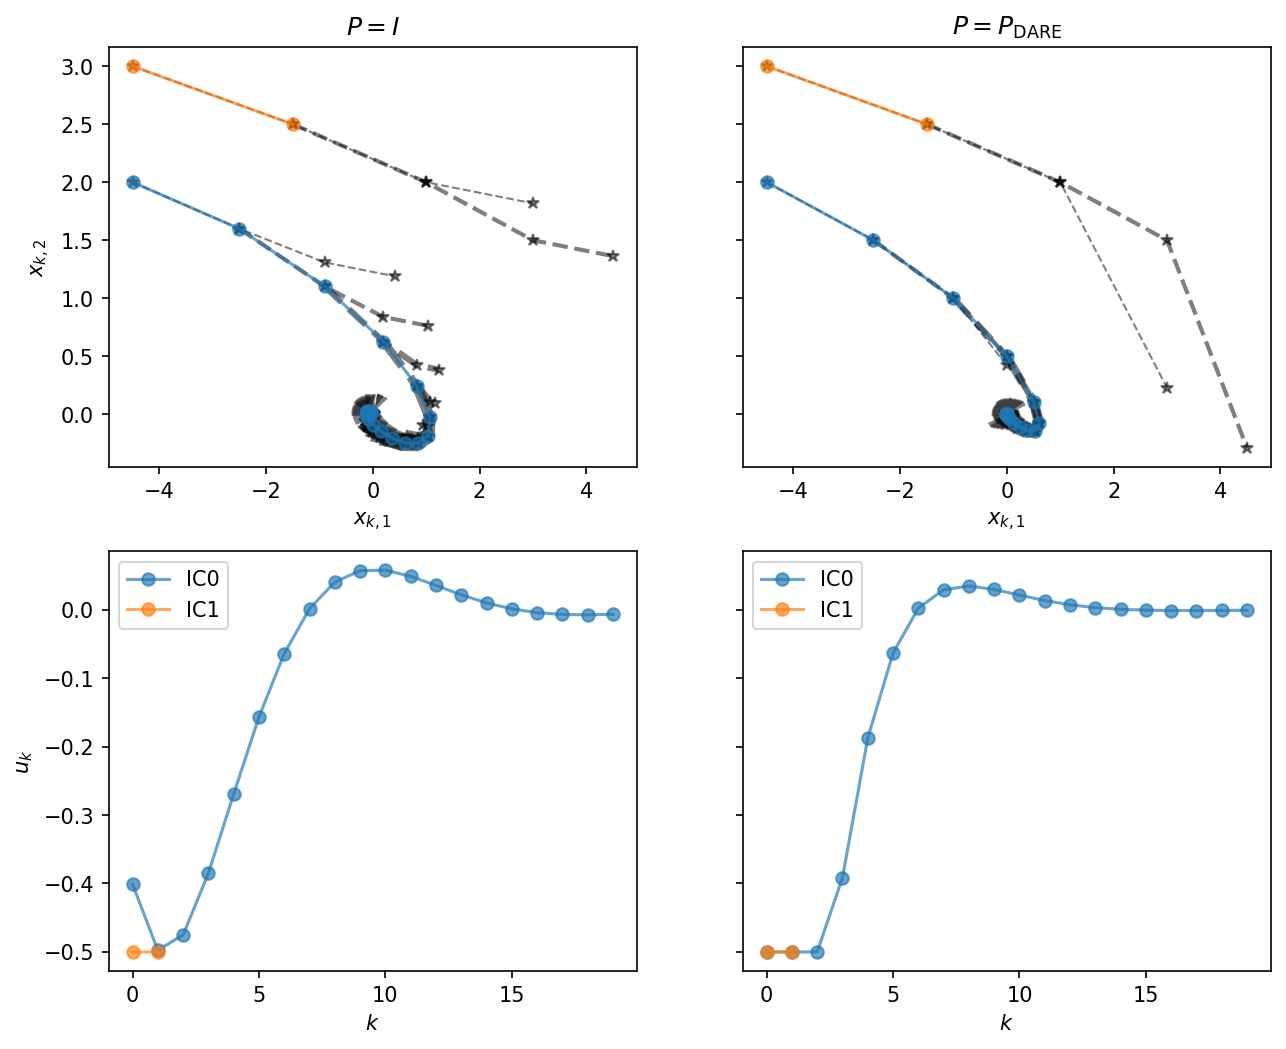

In [54]:
# Part (a): Simulate and plot trajectories of the closed-loop system
n, m = 2, 1
A = np.array([[1.0, 1.0], [0.0, 1.0]])
B = np.array([[0.0], [1.0]])
Q = np.eye(n)
R = 10.0 * np.eye(m)
P_dare = solve_discrete_are(A, B, Q, R)
N = 3
T = 20
rx = 5.0
ru = 0.5
rf = np.inf

Ps = (np.eye(n), P_dare)
titles = (r"$P = I$", r"$P = P_\mathrm{DARE}$")
x0s = (np.array([-4.5, 2.0]), np.array([-4.5, 3.0]))

fig, ax = plt.subplots(2, len(Ps), dpi=150, figsize=(10, 8), sharex="row", sharey="row")
for i, (P, title) in enumerate(zip(Ps, titles)):
    for j, x0 in enumerate(x0s):
        x = np.copy(x0)
        x_mpc = np.zeros((T, N + 1, n))
        u_mpc = np.zeros((T, N, m))
        for t in range(T):
            x_mpc[t], u_mpc[t], status = do_mpc(x, A, B, P, Q, R, N, rx, ru, rf)
            if status == "infeasible":
                print('IC', j, ' hit infeasibility')
                x_mpc = x_mpc[:t]
                u_mpc = u_mpc[:t]
                break
            x = A @ x + B @ u_mpc[t, 0, :]   # Pick out the first control out of the optimized contro sequence
            ax[0, i].plot(x_mpc[t, :, 0], x_mpc[t, :, 1], "--*", color="k", linewidth=1+t, alpha=1/2)
        ax[0, i].plot(x_mpc[:, 0, 0], x_mpc[:, 0, 1], "-o", alpha=2/3)
        ax[1, i].plot(u_mpc[:, 0], "-o", alpha=2/3, label='IC%d'%j)
    ax[0, i].set_title(title)
    ax[0, i].set_xlabel(r"$x_{k,1}$")
    ax[1, i].set_xlabel(r"$k$")
    ax[1, i].legend()
ax[0, 0].set_ylabel(r"$x_{k,2}$")
ax[1, 0].set_ylabel(r"$u_k$")
fig.savefig("mpc_feasibility_sim.png", bbox_inches="tight")
plt.show()

### Discussion Part a

Across the board, we observe that IC0 is able to converge independent of the choice of $P$, whereas IC1 is consistently met with infeasibility and fails.

We also observe that for IC0 which always converges, choosing $P$ as the result of discrete algebraic Riccati equation (DARE) allows the control to reach a steady state sooner (around k=11) while the naive choice of $P$ only approach a steady state control around k=15 



## Part B

In [47]:
def compute_roa(
    A: np.ndarray,
    B: np.ndarray,
    P: np.ndarray,
    Q: np.ndarray,
    R: np.ndarray,
    N: int,                 # receding-horizon length
    rx: float,
    ru: float,
    rf: float,
    grid_dim: int = 21,
    max_steps: int = 20,
    tol: float = 1e-2,
) -> np.ndarray:
    """Compute a region of attraction."""
    roa = np.zeros((grid_dim, grid_dim))
    xs = np.linspace(-rx, rx, grid_dim)
    for i, x1 in enumerate(xs):
        for j, x2 in enumerate(xs):
            x = np.array([x1, x2])
            # PART (b): YOUR CODE BELOW #######################################
            # INSTRUCTIONS: Simulate the closed-loop system for `max_steps`,
            #               stopping early only if the problem becomes
            #               infeasible or the state has converged close enough
            #               to the origin. If the state converges, flag the
            #               corresponding entry of `roa` with a value of `1`.
            x_mpc = np.zeros((T, N + 1, n))
            u_mpc = np.zeros((T, N, m))
            for t in range(max_steps):
                x_mpc[t], u_mpc[t], status = do_mpc(x, A, B, P, Q, R, N, rx, ru, rf)
                
                if status == "infeasible":
                    # print((i,x1), (j, x2), ' hit infeasibility')
                    # x_mpc = x_mpc[:t]
                    # u_mpc = u_mpc[:t]
                    roa[i,j] = 0
                    break
                
                x = A @ x + B @ u_mpc[t, 0, :]

                if np.max(np.abs(x)) < tol:
                    roa[i,j] = 1
                    break

            # END PART (b) ####################################################
    return roa

Computing regions of attraction (this may take a while) ... 


  0%|          | 0/4 [00:00<?, ?it/s]

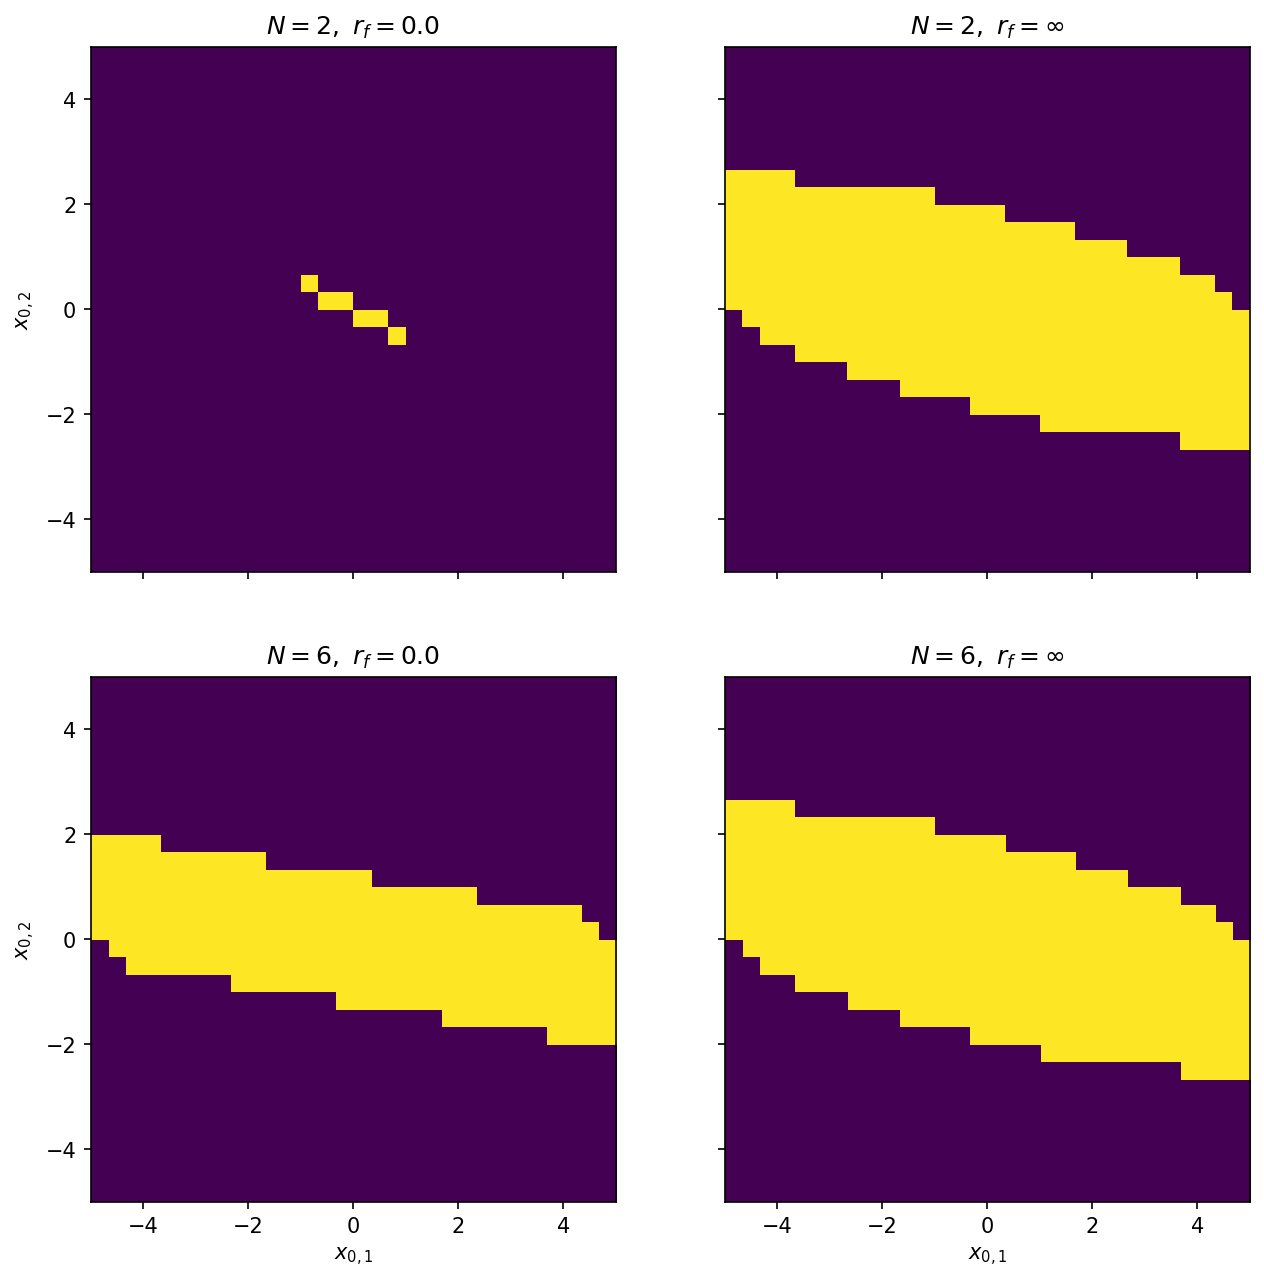

In [55]:
# Part (b): Compute and plot regions of attraction for different MPC parameters
print("Computing regions of attraction (this may take a while) ... ", flush=True)
Ns = (2, 6)
rfs = (0.0, np.inf)
fig, axes = plt.subplots(
    len(Ns), len(rfs), dpi=150, figsize=(10, 10), sharex=True, sharey=True
)
prog_bar = tqdm(product(Ns, rfs), total=len(Ns) * len(rfs))
for flat_idx, (N, rf) in enumerate(prog_bar):
    i, j = np.unravel_index(flat_idx, (len(Ns), len(rfs)))
    roa = compute_roa(A, B, P_dare, Q, R, N, rx, ru, rf, grid_dim=30)
    axes[i, j].imshow(
        roa.T, origin="lower", extent=[-rx, rx, -rx, rx], interpolation="none"
    )
    axes[i, j].set_title(
        r"$N = {},\ r_f = $".format(N) + (r"$\infty$" if rf == np.inf else str(rf))
    )
for ax in axes[-1, :]:
    ax.set_xlabel(r"$x_{0,1}$")
for ax in axes[:, 0]:
    ax.set_ylabel(r"$x_{0,2}$")
fig.savefig("mpc_feasibility_roa.png", bbox_inches="tight")
plt.show()

### Discussion Part b

In general, we observe two trends:

- given the same terminal penalty matrix $P$, longer receding horizons correspond to a larger region of attraction in the state space
- given the same receding horizon length $N$, a less restrictive set of values that $x_f$ can take on correspond to a larger region of attraction in the state space
